<a href="https://colab.research.google.com/github/asnanimayur/Image-captioning-bot/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import numpy as np
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.layers.merge import add


# Image Captioning
- Generating caption for images

# steps
- data collection
- understanding data
- data cleaning
- loading the training set
- data preprocessing - images
- data preprocessing - captions
- data prepration using Generator func
- word embeddings
- model architecture
- inference
- evaluation

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_ref=zipfile.ZipFile('/content/drive/MyDrive/Flickr_Data.zip')
zip_ref.extractall()
zip_ref.close()

In [5]:
folders=os.listdir('Flickr_Data')
folders.remove('.DS_Store')
folders

['Flickr_Data']

In [6]:
# read captions

def readTextFile(path):
  with open(path) as f:
    captions=f.read()
  return captions

In [7]:
captions=readTextFile('Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')


In [8]:
captions=captions.split('\n')[:-1]

In [9]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [10]:
len(captions) # these many captions

40460

In [11]:
# dictionary to map each image with list of captions it has

descriptions={}

# we iterate over every element in caption

for x in captions:
  l=x.split('\t')
  first,second=l[0],l[1]
  img_name=first.split('.')[0]

  # if image id is already present or not
  if descriptions.get(img_name) is None:
    descriptions[img_name]=[] # if not present then emoty list

  
  descriptions[img_name].append(second)


In [12]:
captions[0].split('\t') # we split about tab to get image id and caption

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [13]:
first,second=captions[0].split('\t')
print(first)
first.split('.')[0] # to get image name

1000268201_693b08cb0e.jpg#0


'1000268201_693b08cb0e'

In [14]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [15]:
# Images and captions

import cv2
import matplotlib.pyplot as plt

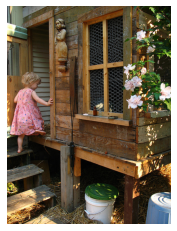

In [16]:
img_path='Flickr_Data/Flickr_Data/Images/'

img=cv2.imread(img_path+'1000268201_693b08cb0e.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)
plt.show()

## Data cleaning

In [17]:
def clean_text(sentence):
  # convert everything to lower case
  sentence=sentence.lower()
  # we will subtitute anything which is not an alphabet with space using reg expression
  sentence=re.sub('[^a-z]+'," ",sentence) # ^ not an alphabet
  sentence=sentence.split()
  
  sentence=[s for s in sentence if len(s)>1]
  sentence=' '.join(sentence)
  return sentence

In [18]:
clean_text('A cat is sitting over the house # 64')

'cat is sitting over the house'

In [19]:
# clean all captions

for key,caption_list in descriptions.items():
  for i in range(len(caption_list)):
    caption_list[i]=clean_text(caption_list[i])

In [20]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [21]:
# write the data to text file (store work)

with open('Flickr_Data/descriptions.txt','w') as f:
  f.write(str(descriptions))


### Vocabulary

In [22]:
descriptions=None
with open('Flickr_Data/descriptions.txt','r') as f:
  descriptions=f.read() # now it will be string



In [23]:
print(type(descriptions)) # read as string 

<class 'str'>


In [24]:
# we convert it to python dictionary

json_acceptable_string=descriptions.replace("'","\"") # we replace single quotes with backlast in json
descriptions=json.loads(json_acceptable_string)

In [25]:
print(type(descriptions)) # we convert it to dict as reading file will load it as string

<class 'dict'>


In [26]:
# vocab

vocab=set() # stores all unique words
for key in descriptions.keys():
  [vocab.update(sentence.split()) for sentence in descriptions[key]] # we add all elements of list in vocab

print('Vocab Size : %d'%len(vocab)) # we have 8424 unique words

Vocab Size : 8424


In [27]:
# total number of words across all sentences

total_words=[]
for key in descriptions.keys():
  [total_words.append(i) for des in descriptions[key] for i in des.split()]

print('Total words : %d'%len(total_words))

Total words : 373837


In [28]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [29]:
# we will remove words having freq less than a threshold - infrequent words
# filter words from vocab acc to certain threshold frequency

import collections

counter=collections.Counter(total_words) # freq count of each word
freq_cnt=dict(counter)
print(freq_cnt)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [30]:
print(len(freq_cnt.keys()))

8424


In [31]:
# sort this dict according to the freq count

sorted_freq_count=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1]) 
# x[1] as comparison will be done based on values not keys as x will be ('a':23) tuple with word and freq 

# filter
threshold=10
sorted_freq_count=[x for x in sorted_freq_count if x[1]>threshold]

total_words=[x[0] for x in sorted_freq_count]

In [32]:
sorted_freq_count

[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her', 1178),
 ('walk

In [33]:
print(len(total_words)) # from 357791 words we now have 1845 word by filerting out unique words and then applying freq threshold

1845


# Prepare Train/Test Data

In [34]:
train_file_data=readTextFile('Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt')

In [35]:
test_file_data=readTextFile('Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt')

In [36]:
print(train_file_data[-1])
# we remove last one and we split images

In [37]:
# also remove jpg

train=[row.split('.')[0] for row in train_file_data.split('\n')[:-1]] # split row by '.' and extract 0 element, image id
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [38]:
# same for test
test=[row.split('.')[0] for row in test_file_data.split('\n')[:-1]] # split row by '.' and extract 0 element, image id
test[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

In [39]:
# prepare descriptions for training data

# tweak- we add a start <s> and end <e> token to our training data

train_descriptions={}

for img_id in train: # train is list of image ids
  train_descriptions[img_id]=[]
  # we add captions to this list
  for cap in descriptions[img_id]:
    cap_to_append='startseq '+cap+" endseq"
    train_descriptions[img_id].append(cap_to_append)


In [40]:
train_descriptions['1000268201_693b08cb0e'] # we now have start seq and end seq for each sentence

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Transfer learning
- images --> features
- text --> features

# step-1
- Image feature extraction

In [41]:
model=ResNet50(weights='imagenet',input_shape=(224,224,3))

model.summary()


102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [42]:
model.layers[-2] # second last layer is GlobalAvgPooling

In [43]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [44]:
model_new=Model(model.input,model.layers[-2].output) # we want our model to output 2048 params (GAP layer)

In [45]:
# we feed some images to resnet50, extract feature vectors

# preprocss images

In [46]:
def preprocess_img(img):
  img=image.load_img(img,target_size=(224,224))
  img=image.img_to_array(img)
  img=np.expand_dims(img,axis=0)
  # normalisation
  img=preprocess_input(img)

  return img
  

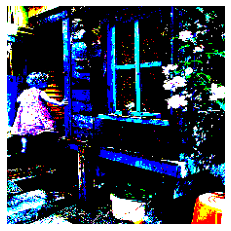

In [47]:
img=preprocess_img(img_path+'1000268201_693b08cb0e.jpg')
plt.imshow(img[0]) # as its a 4d tensor
plt.axis('off')
plt.show()
# mean of every channel across every channel and do mean subtraction

In [48]:
# we do this for every image to get [mx2048] dim feature vector called encoding

In [49]:
def encode_img(img):
  # 1. preprocessing
  img=preprocess_img(img)
  # and we feed it to our model, 2. feed
  feature_vector=model_new.predict(img)
  # print(feature_vector.shape) # the shape is (1,2048)
  feature_vector=feature_vector.reshape((2048,)) # we reshape it into just (2048) scalar
  # print(feature_vector.shape)
  return feature_vector

In [50]:
encode_img(img_path+'1000268201_693b08cb0e.jpg')

array([0.06535938, 0.16782549, 0.3251763 , ..., 0.05107132, 0.32821193,
       1.004337  ], dtype=float32)

In [51]:
# encode all images, iterate over all images and save them in one file

start=time()
img_path1='Flickr_Data/Flickr_Data/Images'
encoding_train={}
# map each image id--> feature_vector extracted from resnet50

for ix,img_id in enumerate(train): # will give us index and id
  img_path=img_path1+'/'+img_id+'.jpg'
  encoding_train[img_id]=encode_img(img_path) # feature vector of images

  if ix%100==0: # after every 100 images
    print('Ecoding in progress Time step %d'%ix)

end_t=time()
print('Total Time Taken : ',end_t-start)


Ecoding in progress Time step 0
Ecoding in progress Time step 100
Ecoding in progress Time step 200
Ecoding in progress Time step 300
Ecoding in progress Time step 400
Ecoding in progress Time step 500
Ecoding in progress Time step 600
Ecoding in progress Time step 700
Ecoding in progress Time step 800
Ecoding in progress Time step 900
Ecoding in progress Time step 1000
Ecoding in progress Time step 1100
Ecoding in progress Time step 1200
Ecoding in progress Time step 1300
Ecoding in progress Time step 1400
Ecoding in progress Time step 1500
Ecoding in progress Time step 1600
Ecoding in progress Time step 1700
Ecoding in progress Time step 1800
Ecoding in progress Time step 1900
Ecoding in progress Time step 2000
Ecoding in progress Time step 2100
Ecoding in progress Time step 2200
Ecoding in progress Time step 2300
Ecoding in progress Time step 2400
Ecoding in progress Time step 2500
Ecoding in progress Time step 2600
Ecoding in progress Time step 2700
Ecoding in progress Time step 28

In [52]:
# store everything to disk , it took alot of time to preprocess all images so we save in disk to not lose it

with open('Flickr_Data/encoded_train_features.pkl','wb') as f:
  # store
  pickle.dump(encoding_train,f) # encoding train to dump and file pointer where to dump



In [53]:
# for test set

start=time()
img_path1='Flickr_Data/Flickr_Data/Images'
encoding_test={}
# map each image id--> feature_vector extracted from resnet50

for ix,img_id in enumerate(test): # will give us index and id
  img_path=img_path1+'/'+img_id+'.jpg'
  encoding_test[img_id]=encode_img(img_path) # feature vector of images

  if ix%100==0: # after every 100 images
    print('Test Ecoding in progress Time step %d'%ix)

end_t=time()
print('Total Time Taken(test) : ',end_t-start)



Test Ecoding in progress Time step 0
Test Ecoding in progress Time step 100
Test Ecoding in progress Time step 200
Test Ecoding in progress Time step 300
Test Ecoding in progress Time step 400
Test Ecoding in progress Time step 500
Test Ecoding in progress Time step 600
Test Ecoding in progress Time step 700
Test Ecoding in progress Time step 800
Test Ecoding in progress Time step 900
Total Time Taken(test) :  202.55891704559326


In [54]:
with open('Flickr_Data/encoded_test_features.pkl','wb') as f:
  # store
  pickle.dump(encoding_test,f)

# data preprocessing for captions


In [55]:
# iterate over all words

# vocab 
len(total_words) # these will form our vocab


1845

In [56]:
word_to_idx={} # maps words to index
idx_to_word={} # maps index to word

for i,word in enumerate(total_words): # gives index as well as word
  word_to_idx[word]=i+1 
  # as we will not use index 0 as we will put 0 when word is not there
  idx_to_word[i+1]=word


In [57]:
word_to_idx['dog']

6

In [58]:
idx_to_word[1]

'in'

In [59]:

len(word_to_idx)

1845

In [60]:
# we add two special words <s> start seq and <e> end seq

idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846

idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847

vocab_size=len(word_to_idx)+1

print('Vocab Size ',vocab_size)

Vocab Size  1848


In [61]:
# finding maximum length of caption

max_len=0

for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_len=max(max_len,len(cap.split())) # max of max_len and curr caption

print(max_len)

35


# Data Generator

In [62]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
  '''train descr is a dict which maps image id with captions 
  encoding train - how a particular image is mapped with a 2048 vector,
  word_to_idx - how a word is mapped to an index,
  max_len - max len of caption
  batch size- how many training examples we should have in batch'''

  x1,x2,y=[],[],[] # batches

  n=0
  while True :
    for key,desc_list in train_descriptions.items(): # key is image_id,desc_list is list of captions
      n+=1 # read an image
      photo=encoding_train[key] # image path , key-image_id       
      # for all captions - for single image we have multiple captions
      for desc in desc_list:
        # we pick one seq and convert it into number
        seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
        for i in range(1,len(seq)):
          xi=seq[0:i] # input
          yi=seq[i] # predictions 
          
          # pad xi, 0 denotes padding word, post padding as we add it after seq
          xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0] # padding of 0 till max_len, and we get 0th element
          # we access 0 example as it outputs 2d list and it has one element
          yi=to_categorical([yi],num_classes=vocab_size)[0] # we make yi as one hot vector

          x1.append(photo) # image
          x2.append(xi)    # input seq
          y.append(yi)

        if n==batch_size:
          yield ([np.array(x1),np.array(x2)],np.array(y)) # we combine x1 and x2

          # we use yield as generator stores everything not return 

          x1,x2,y=[],[],[] # as we dont add examples which were already there in previous batch

          n=0

        

        

                                                                  


In [63]:
f=open('glove.6B.50d.txt')

In [64]:
embedding_index={} # dict will store word vector for every word

for line in f: # read every line
  values = line.split() # first ele is word and next 50 are the embeddings
  # print(values) 
  word=values[0]
  word_embedding = np.array(values[1:],dtype='float')
  embedding_index[word]=word_embedding
  

In [65]:
f.close()

In [66]:
embedding_index['apple'] # embedding for apple

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [67]:
# we now build embedding matrix

def get_embedding_matrix():
  emb_dim=50 # as each word is represented as 50 dim vector
  matrix=np.zeros((vocab_size,emb_dim))
  # we iterate over all words in word_to_idx dict
  for word,idx in word_to_idx.items():
    embedding_vector=embedding_index.get(word)

    if embedding_vector is not None:
      matrix[idx]=embedding_vector

  return matrix



In [68]:
embedding_matrix=get_embedding_matrix()
print(embedding_matrix.shape) # 1848 is vocab size

(1848, 50)


In [69]:
print(type(word_to_idx))

<class 'dict'>


In [70]:
word_to_idx['the']

2

In [71]:
# embedding for start seq- index 1847

embedding_matrix[1847] # is 0 because start seq words is not in glove embedding

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Model Architecture

In [72]:
# image feature extracter

input_img_features=Input(shape=(2048,)) # resnet output will go into this layer
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)



In [73]:
# captions as input

input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2) # 256 is output size



In [74]:
decoder1=add([inp_img2,inp_cap3]) # inp_cap3 captures the entire sentence generated till now
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)


# combine model

model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [75]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [76]:
# Important thing - preinitialise Embedding Layer

model.layers[2].set_weights([embedding_matrix]) # we initialise it with our weights
model.layers[2].trainable=False

In [77]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

# Training of Model

In [78]:
epochs=20
batch_size=3
steps=len(train_descriptions)//batch_size



In [80]:
for i in range(epochs):
  generator=data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1) # the batch will pass once in that particular epoch
  model.save('Flickr_Data/model_weights/model_'+str(i)+'.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2000/2000 [==============================] - 622s 311ms/step - loss: 2.5544


In [81]:
model=load_model('Flickr_Data/model_weights/model_9.h5')

# Predictions

In [82]:
def predict_caption(photo):
  in_text='startseq'
  for i in range(max_len):
    sequence=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence=pad_sequences([sequence],maxlen=max_len,padding='post')

    ypred=model.predict([photo,sequence])
    ypred=ypred.argmax() # word with max prob- greedy sampling
    word=idx_to_word[ypred] # we get th word
    in_text+= (' '+word) # we add the word to our input text
    if word=='endseq':
      break

  final_caption=in_text.split()[1:-1] # ignore first and last word
  final_caption=' '.join(final_caption)

  return final_caption

the boy is wearing white shirt and holding football ball


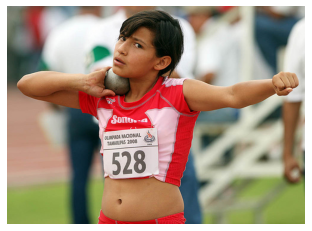

man in blue shirt and shorts is riding bicycle down the street


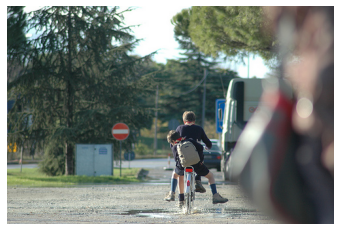

swimmer in the air


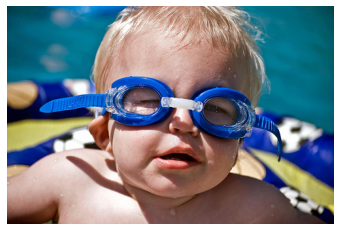

dog running through snow


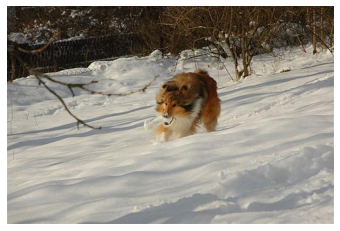

young girl in blue shirt is sitting on the beach


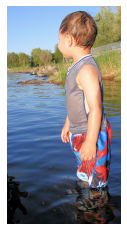

skier is jumping over snow covered hill


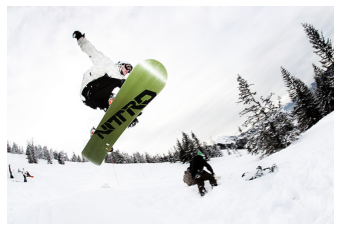

dog is jumping over some logs


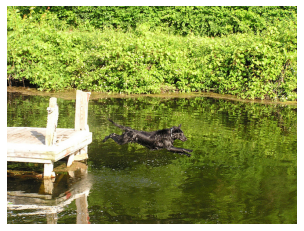

dog jumping over hurdle


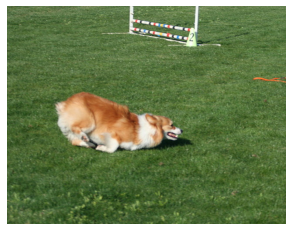

little girl in pink dress is playing in the snow


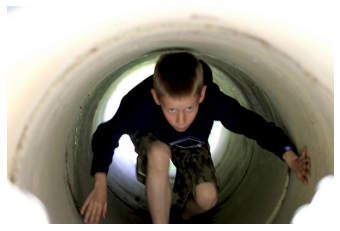

dog is running through the grass


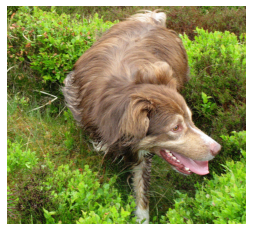

man in black shirt and black cap walks down the street


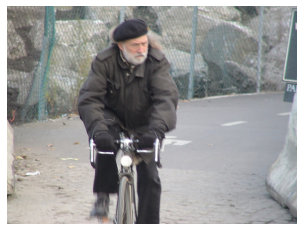

white dog running on the grass


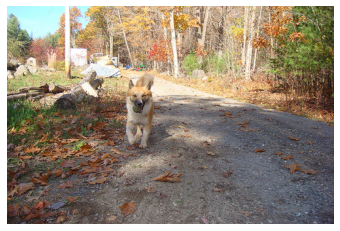

little girl in pink shirt is playing with hula hoops


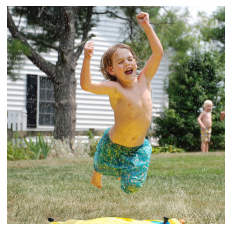

three men sit on bench in front of window


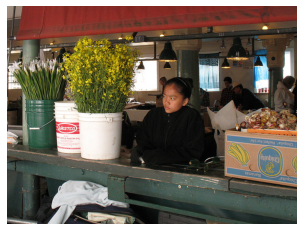

black dog is tugging on the blanket


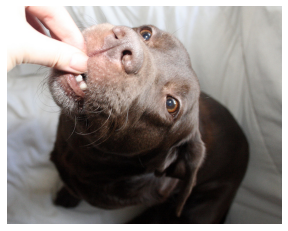

In [85]:
# pick some random images and see results

img_path='Flickr_Data/Flickr_Data/Images/'
for i in range(15):
  idx=np.random.randint(0,1000)
  all_img_names=list(encoding_test.keys())
  img_name=all_img_names[idx] # we pick random image
  photo_2048=encoding_test[img_name].reshape((1,2048))
  i=plt.imread(img_path+img_name+'.jpg')
  
  caption=predict_caption(photo_2048) # to get corresponding caption
  print(caption)
  plt.imshow(i)
  plt.axis('off')
  plt.show()